# Time Series Filters

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

In [3]:
dta = sm.datasets.macrodata.load_pandas().data

In [4]:
index = pd.Index(sm.tsa.datetools.dates_from_range("1959Q1", "2009Q3"))
print(index)

DatetimeIndex(['1959-03-31', '1959-06-30', '1959-09-30', '1959-12-31',
               '1960-03-31', '1960-06-30', '1960-09-30', '1960-12-31',
               '1961-03-31', '1961-06-30',
               ...
               '2007-06-30', '2007-09-30', '2007-12-31', '2008-03-31',
               '2008-06-30', '2008-09-30', '2008-12-31', '2009-03-31',
               '2009-06-30', '2009-09-30'],
              dtype='datetime64[ns]', length=203, freq=None)


In [5]:
dta.index = index
del dta["year"]
del dta["quarter"]

In [6]:
print(sm.datasets.macrodata.NOTE)

::
    Number of Observations - 203

    Number of Variables - 14

    Variable name definitions::

        year      - 1959q1 - 2009q3
        quarter   - 1-4
        realgdp   - Real gross domestic product (Bil. of chained 2005 US$,
                    seasonally adjusted annual rate)
        realcons  - Real personal consumption expenditures (Bil. of chained
                    2005 US$, seasonally adjusted annual rate)
        realinv   - Real gross private domestic investment (Bil. of chained
                    2005 US$, seasonally adjusted annual rate)
        realgovt  - Real federal consumption expenditures & gross investment
                    (Bil. of chained 2005 US$, seasonally adjusted annual rate)
        realdpi   - Real private disposable income (Bil. of chained 2005
                    US$, seasonally adjusted annual rate)
        cpi       - End of the quarter consumer price index for all urban
                    consumers: all items (1982-84 = 100, seasonally adju

In [7]:
print(dta.head(10))

             realgdp  realcons  realinv  realgovt  realdpi    cpi     m1  \
1959-03-31  2710.349    1707.4  286.898   470.045   1886.9  28.98  139.7   
1959-06-30  2778.801    1733.7  310.859   481.301   1919.7  29.15  141.7   
1959-09-30  2775.488    1751.8  289.226   491.260   1916.4  29.35  140.5   
1959-12-31  2785.204    1753.7  299.356   484.052   1931.3  29.37  140.0   
1960-03-31  2847.699    1770.5  331.722   462.199   1955.5  29.54  139.6   
1960-06-30  2834.390    1792.9  298.152   460.400   1966.1  29.55  140.2   
1960-09-30  2839.022    1785.8  296.375   474.676   1967.8  29.75  140.9   
1960-12-31  2802.616    1788.2  259.764   476.434   1966.6  29.84  141.1   
1961-03-31  2819.264    1787.7  266.405   475.854   1984.5  29.81  142.1   
1961-06-30  2872.005    1814.3  286.246   480.328   2014.4  29.92  142.9   

            tbilrate  unemp      pop  infl  realint  
1959-03-31      2.82    5.8  177.146  0.00     0.00  
1959-06-30      3.08    5.1  177.830  2.34     0.74  
1

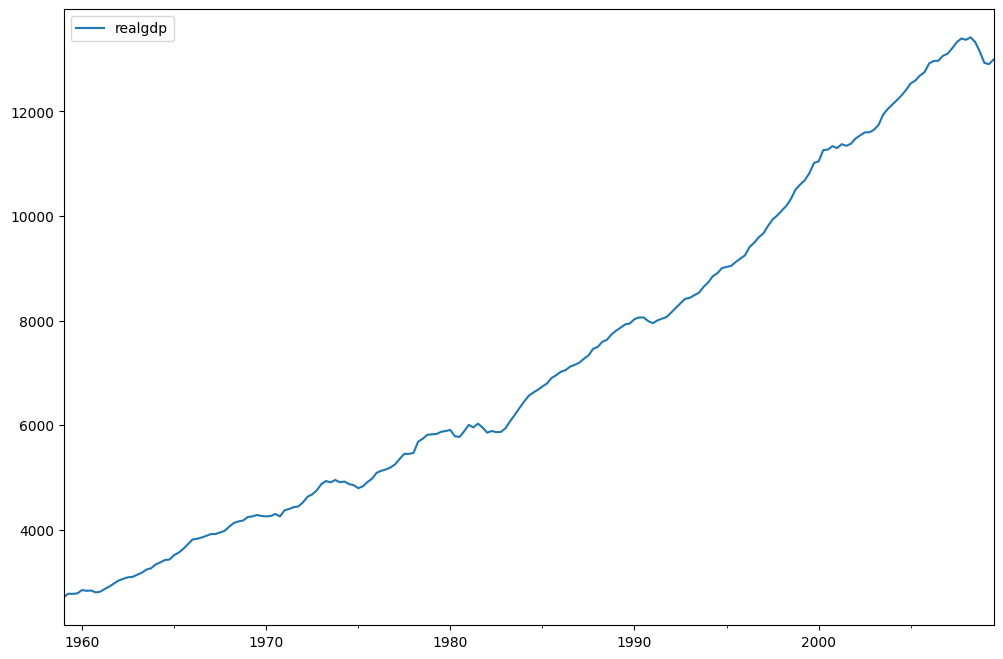

In [8]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
dta.realgdp.plot(ax=ax)
legend = ax.legend(loc="upper left")
legend.prop.set_size(20)

### Hodrick-Prescott Filter

The Hodrick-Prescott filter separates a time-series $y_t$ into a trend $\tau_t$ and a cyclical component $\zeta_t$ 

$$y_t = \tau_t + \zeta_t$$

The components are determined by minimizing the following quadratic loss function

$$\min_{\\{ \tau_{t}\\} }\sum_{t}^{T}\zeta_{t}^{2}+\lambda\sum_{t=1}^{T}\left[\left(\tau_{t}-\tau_{t-1}\right)-\left(\tau_{t-1}-\tau_{t-2}\right)\right]^{2}$$

In [9]:
gdp_cycle, gdp_trend = sm.tsa.filters.hpfilter(dta.realgdp)

In [10]:
gdp_decomp = dta[["realgdp"]].copy()
gdp_decomp["cycle"] = gdp_cycle
gdp_decomp["trend"] = gdp_trend

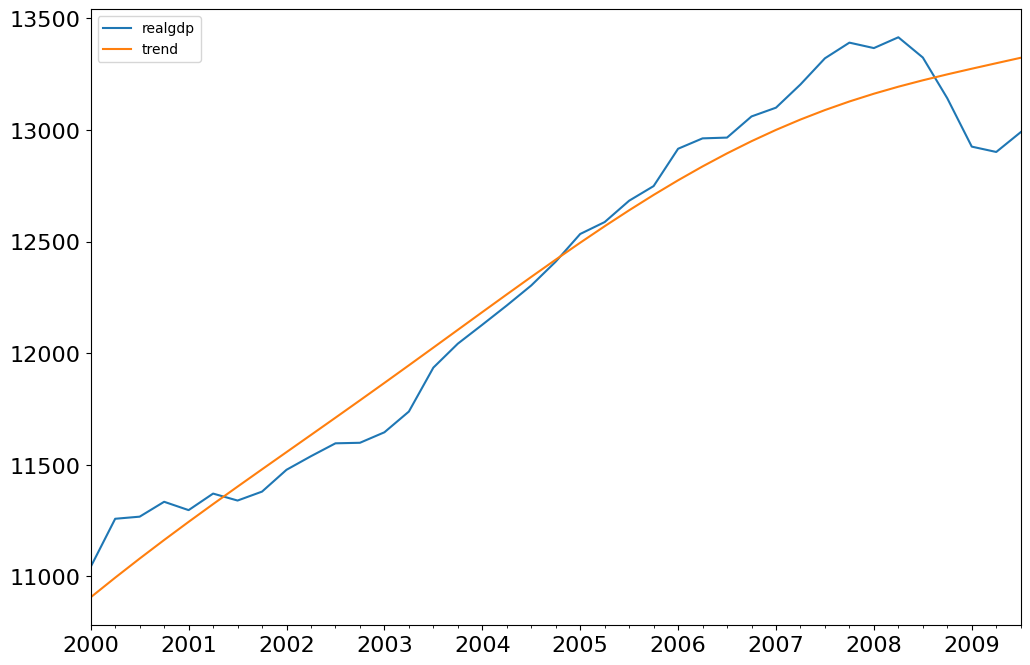

In [11]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
gdp_decomp[["realgdp", "trend"]]["2000-03-31":].plot(ax=ax, fontsize=16)
legend = ax.get_legend()
legend.prop.set_size(20)

### Baxter-King approximate band-pass filter: Inflation and Unemployment

#### Explore the hypothesis that inflation and unemployment are counter-cyclical.

The Baxter-King filter is intended to explicitly deal with the periodicity of the business cycle. By applying their band-pass filter to a series, they produce a new series that does not contain fluctuations at higher or lower than those of the business cycle. Specifically, the BK filter takes the form of a symmetric moving average 

$$y_{t}^{*}=\sum_{k=-K}^{k=K}a_ky_{t-k}$$

where $a_{-k}=a_k$ and $\sum_{k=-k}^{K}a_k=0$ to eliminate any trend in the series and render it stationary if the series is I(1) or I(2).

For completeness, the filter weights are determined as follows

$$a_{j} = B_{j}+\theta\text{ for }j=0,\pm1,\pm2,\dots,\pm K$$

$$B_{0} = \frac{\left(\omega_{2}-\omega_{1}\right)}{\pi}$$
$$B_{j} = \frac{1}{\pi j}\left(\sin\left(\omega_{2}j\right)-\sin\left(\omega_{1}j\right)\right)\text{ for }j=0,\pm1,\pm2,\dots,\pm K$$

where $\theta$ is a normalizing constant such that the weights sum to zero.

$$\theta=\frac{-\sum_{j=-K^{K}b_{j}}}{2K+1}$$

$$\omega_{1}=\frac{2\pi}{P_{H}}$$

$$\omega_{2}=\frac{2\pi}{P_{L}}$$

$P_L$ and $P_H$ are the periodicity of the low and high cut-off frequencies. Following Burns and Mitchell's work on US business cycles which suggests cycles last from 1.5 to 8 years, we use $P_L=6$ and $P_H=32$ by default.

In [12]:
bk_cycles = sm.tsa.filters.bkfilter(dta[["infl", "unemp"]])

* We lose K observations on both ends. It is suggested to use K=12 for quarterly data.

<Axes: >

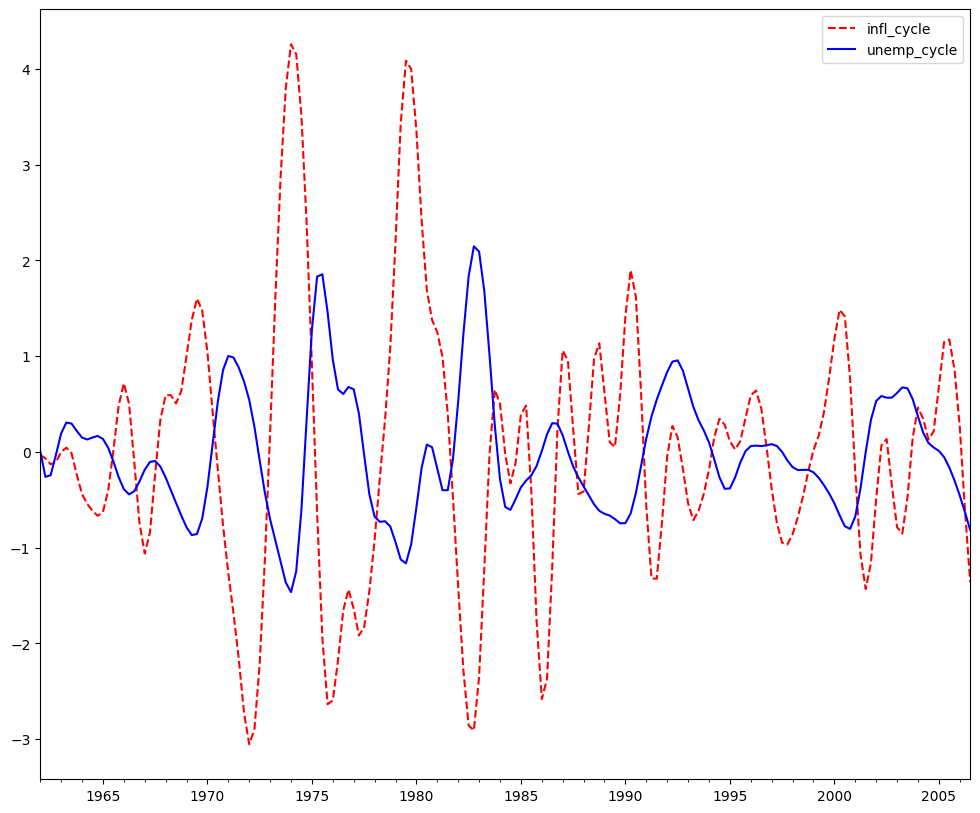

In [13]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)
bk_cycles.plot(ax=ax, style=["r--", "b-"])

### Christiano-Fitzgerald approximate band-pass filter: Inflation and Unemployment

The Christiano-Fitzgerald filter is a generalization of BK and can thus also be seen as weighted moving average. However, the CF filter is asymmetric about $t$ as well as using the entire series. The implementation of their filter involves the
calculations of the weights in

$$y_{t}^{*}=B_{0}y_{t}+B_{1}y_{t+1}+\dots+B_{T-1-t}y_{T-1}+\tilde B_{T-t}y_{T}+B_{1}y_{t-1}+\dots+B_{t-2}y_{2}+\tilde B_{t-1}y_{1}$$

for $t=3,4,...,T-2$, where

$$B_{j} = \frac{\sin(jb)-\sin(ja)}{\pi j},j\geq1$$

$$B_{0} = \frac{b-a}{\pi},a=\frac{2\pi}{P_{u}},b=\frac{2\pi}{P_{L}}$$

$\tilde B_{T-t}$ and $\tilde B_{t-1}$ are linear functions of the $B_{j}$'s, and the values for $t=1,2,T-1,$ and $T$ are also calculated in much the same way. $P_{U}$ and $P_{L}$ are as described above with the same interpretation.

The CF filter is appropriate for series that may follow a random walk.

In [14]:
print(sm.tsa.stattools.adfuller(dta["unemp"])[:3])

(np.float64(-2.53645846733463), np.float64(0.10685366457233608), 9)


In [15]:
print(sm.tsa.stattools.adfuller(dta["infl"])[:3])

(np.float64(-3.054514496257235), np.float64(0.030107620863486007), 2)


In [16]:
cf_cycles, cf_trend = sm.tsa.filters.cffilter(dta[["infl", "unemp"]])
print(cf_cycles.head(10))

            infl_cycle  unemp_cycle
1959-03-31    0.237927    -0.216867
1959-06-30    0.770007    -0.343779
1959-09-30    1.177736    -0.511024
1959-12-31    1.256754    -0.686967
1960-03-31    0.972128    -0.770793
1960-06-30    0.491889    -0.640601
1960-09-30    0.070189    -0.249741
1960-12-31   -0.130432     0.301545
1961-03-31   -0.134155     0.788992
1961-06-30   -0.092073     0.985356


<Axes: >

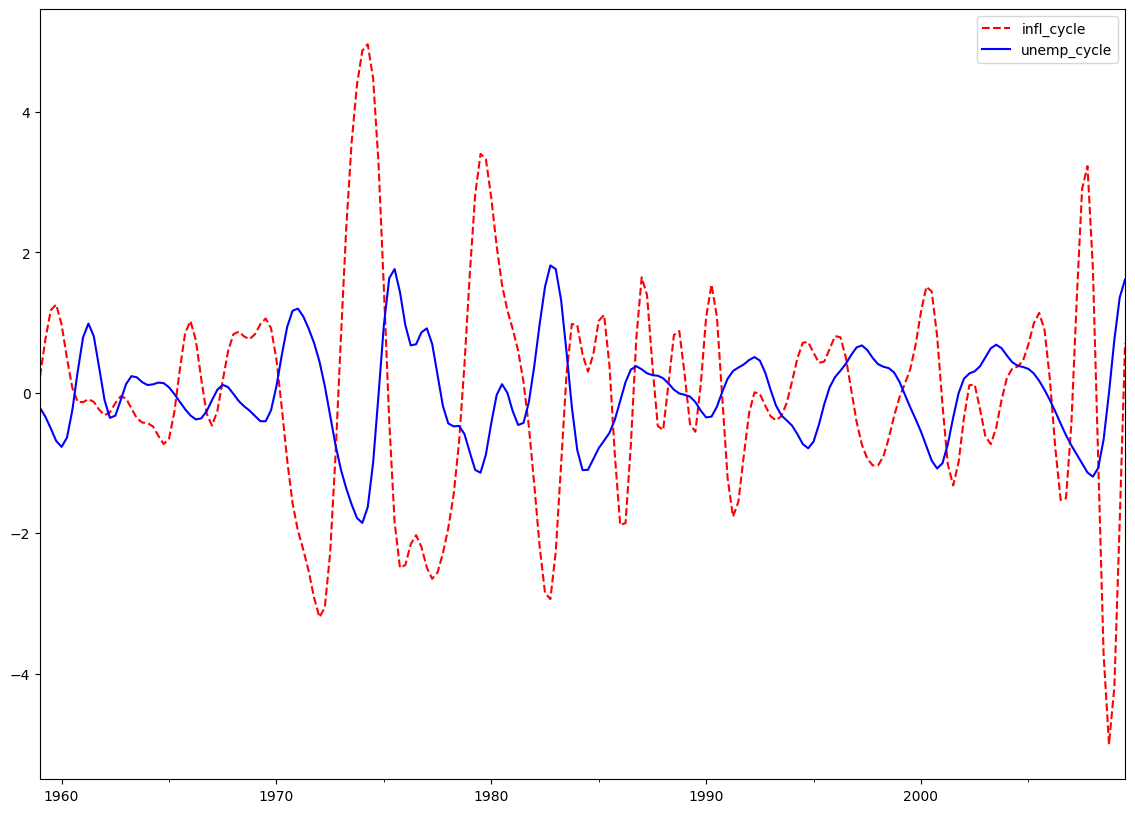

In [17]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)
cf_cycles.plot(ax=ax, style=["r--", "b-"])

Filtering assumes *a priori* that business cycles exist. Due to this assumption, many macroeconomic models seek to create models that match the shape of impulse response functions rather than replicating properties of filtered series. See VAR notebook.